In [113]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
import joblib
from pathlib import Path
import sqlite3
from sklearn.multioutput import MultiOutputRegressor
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

import sys

sys.path.append('C:/Users/Jordan Nishimura/NBA_Model_v1')

from src.data.process_data_no_split import get_data_from_db_all

In [3]:
connection = sqlite3.connect('../data/nba.db')
pd.read_sql("""SELECT name FROM sqlite_schema WHERE type='table'""", connection)
connection.close()

In [299]:
connection = sqlite3.connect('../data/nba.db')
team_stats_ewa_matchup_prod = pd.read_sql("""SELECT * FROM team_stats_ewa_matchup_prod""", connection)
connection.close()

In [300]:
db_filepath = Path.home().joinpath('NBA_model_v1', 'data', 'nba.db')

X, y, df = get_data_from_db_all(target=['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE'], db_filepath=db_filepath)


C:\Users\Jordan Nishimura\NBA_model_v1\data\nba.db


In [306]:
set(team_stats_ewa_matchup_prod.columns) - set(df.columns)

{'index'}

In [35]:
def season_to_string(season):
    return str(season) + '-' + str(season+1)[-2:]

In [103]:
def tscv_by_season(train_df, test_season, min_training_years=2):
    earliest_year_with_data = 2013

    cv_splits = []

    for year in range(earliest_year_with_data + min_training_years, test_season+1):      
        listTrain = train_df.loc[train_df['SEASON'] < season_to_string(year)].index
        listVal = train_df.loc[train_df['SEASON'] == season_to_string(year)].index        
        cv_splits.append((listTrain, listVal))

    return cv_splits 

In [255]:
def create_betting_df(test_preds, i):
    
    matchup_info_cols = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'MATCHUP',
                        'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                        'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF', 'HOME_WL']

    betting_df = df[matchup_info_cols]

    betting_df = betting_df.loc[cv_splits[i][1]]
    betting_df[['HOME_SCORE_PRED', 'AWAY_SCORE_PRED']] = test_preds
    betting_df['HOME_SCORE_DIFF_PRED'] = betting_df['HOME_SCORE_PRED'] - betting_df['AWAY_SCORE_PRED']

    betting_df['HOME_WL_PRED'] = (betting_df['HOME_SCORE_PRED'] > betting_df['AWAY_SCORE_PRED']).astype(int)

    betting_df['HOME_FAVORED'] = (betting_df['HOME_SPREAD'] < 0).astype(int)

    betting_df['ML_BET_WON'] = (betting_df['HOME_WL_PRED'] == betting_df['HOME_WL']).astype(int)
    betting_df['HOME_COVER_PRED'] = (betting_df['HOME_SCORE_PRED'] + betting_df['HOME_SPREAD'] > betting_df['AWAY_SCORE_PRED']).astype(int)
    betting_df['ATS_BET_WON'] = (betting_df['HOME_COVER_PRED'] == betting_df['HOME_TEAM_COVERED']).astype(int)


    betting_df['BET_FAVORITE'] = (((betting_df['HOME_FAVORED'] == 1) & (betting_df['HOME_COVER_PRED'] == 1)) | ((betting_df['HOME_FAVORED'] == 0) & (betting_df['HOME_COVER_PRED'] == 0))).astype(int)

    betting_df['MODEL_FAV_EQ_VEGAS_FAV'] = (np.sign(betting_df['HOME_SPREAD']) != np.sign(betting_df['HOME_SCORE_DIFF_PRED'])).astype(int)
    betting_df['MODEL_ATS_DIFF'] = betting_df['HOME_SPREAD'] + betting_df['HOME_SCORE_DIFF_PRED']


    betting_df['MODEL_ATS_DIFF_UNDER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() < 1).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 1).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_2'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 2).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_3'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 3).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_4'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 4).astype(int)
    
    betting_df.loc[betting_df['HOME_SPREAD']==0, 'HOME_FAVORED'] = np.nan
    betting_df.loc[betting_df['HOME_ATS_DIFF']==0, ['HOME_TEAM_COVERED', 'ATS_BET_WON']] = np.nan

    return betting_df

In [266]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index(drop=True)

    selected_bets['bankroll_i'] = np.nan
    selected_bets['bankroll_n'] = np.nan

    selected_bets.loc[selected_bets.index[0], 'bankroll_i'] = 100 

    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()

    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked

    print("min balance:", min_balance,
            "\nmax balance:", max_balance,
            "\nfinal balance:", final_balance,
            "\nwin percentage", round(win_pct, 4) * 100,
            "\nprofit:", profit, "risk:", amt_risked,
            "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [297]:
int(df.loc[X_train.index, 'SEASON'].max()[:4])

2017

In [102]:
cv_splits = [(df.loc[df['SEASON'] < season_to_string(season)].index, df.loc[df['SEASON'] == season_to_string(season)].index) for season in range(2018, 2023)]

In [298]:
for i in range(len(cv_splits)):

    X_train = X.loc[cv_splits[i][0]]
    y_train = y.loc[cv_splits[i][0]]

    X_test = X.loc[cv_splits[i][1]]
    y_test = y.loc[cv_splits[i][1]]
    
    hp_cv_splits = tscv_by_season(df.loc[X_train.index], int(df.loc[X_train.index, 'SEASON'].max()[:4]))
    
    print(X_train.index[0], X_train.index[-1], X_test.index[0], X_test.index[-1])
    print()
    for s in hp_cv_splits:
        print(s[0][0], s[0][-1], s[1][0], s[1][-1])
    print('-----')

0 6162 6171 7457

0 2288 2289 3579
0 3579 3580 4866
0 4866 4867 6162
-----
0 7457 7466 8571

0 2288 2289 3579
0 3579 3580 4866
0 4866 4867 6162
0 6162 6171 7457
-----
0 8571 8572 9720

0 2288 2289 3579
0 3579 3580 4866
0 4866 4867 6162
0 6162 6171 7457
0 7457 7466 8571
-----
0 9720 9730 10954

0 2288 2289 3579
0 3579 3580 4866
0 4866 4867 6162
0 6162 6171 7457
0 7457 7466 8571
0 8571 8572 9720
-----
0 10954 10965 11533

0 2288 2289 3579
0 3579 3580 4866
0 4866 4867 6162
0 6162 6171 7457
0 7457 7466 8571
0 8571 8572 9720
0 9720 9730 10954
-----


In [331]:
i=3

X_train = X.loc[cv_splits[i][0]]
y_train = y.loc[cv_splits[i][0]]

X_test = X.loc[cv_splits[i][1]]
y_test = y.loc[cv_splits[i][1]]

df.loc[X_train.index].head().T.head(20)
# df.loc[X_test.index]

,0,1,2,3,4
SEASON,2013-14,2013-14,2013-14,2013-14,2013-14
HOME_TEAM_ABBREVIATION,POR,DET,CHA,PHI,UTA
GAME_DATE,2013-12-07 00:00:00,2013-12-08 00:00:00,2013-12-09 00:00:00,2013-12-09 00:00:00,2013-12-09 00:00:00
GAME_ID,0021300298,0021300300,0021300304,0021300305,0021300308
MATCHUP,POR vs. DAL,DET vs. MIA,CHA vs. GSW,PHI vs. LAC,UTA vs. POR
HOME_HOME_GAME,1,1,1,1,1
HOME_TEAM_SCORE,106,95,115,83,94
HOME_ML,1.434783,2.5,3.1,5.25,3.6
HOME_SPREAD,-5.5,4.0,6.0,10.0,8.0
HOME_ATS_DIFF,-7.5,-11.0,10.0,-1.0,-3.0


[I 2023-01-08 23:57:34,066] Using an existing study with name 'C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor_backtest0' instead of creating a new one.


Training Seasons: ['2013-14' '2014-15' '2015-16' '2016-17' '2017-18']
Testing Seasons: ['2018-19']



[I 2023-01-08 23:59:31,923] Trial 22 finished with value: -11.077640214181415 and parameters: {'alpha': 0.004435767671096167, 'l1_ratio': 0.8931614678054303}. Best is trial 6 with value: -8.124183808824776.
[I 2023-01-09 00:01:19,379] Trial 23 finished with value: -12.09077352868689 and parameters: {'alpha': 0.013329607289080673, 'l1_ratio': 0.5639686200590716}. Best is trial 6 with value: -8.124183808824776.
[I 2023-01-09 00:03:03,965] Trial 24 finished with value: -12.09077352868689 and parameters: {'alpha': 0.13621821585468658, 'l1_ratio': 0.4184041442570806}. Best is trial 6 with value: -8.124183808824776.
[I 2023-01-09 00:04:49,620] Trial 25 finished with value: -11.838591100219011 and parameters: {'alpha': 0.008580595756897983, 'l1_ratio': 0.5503612422049992}. Best is trial 6 with value: -8.124183808824776.
[I 2023-01-09 00:06:38,351] Trial 26 finished with value: -9.213845286438348 and parameters: {'alpha': 0.0019870609121944477, 'l1_ratio': 0.6839700723814462}. Best is trial 6 

params: {'alpha': 0.019572010206588487, 'epsilon': 18.05269367226997, 'l1_ratio': 0.9205499361237223, 'loss': 'huber'}

train_mae: 7.830292619572257
test_mae: 8.65734399012516

betting results on testing season:


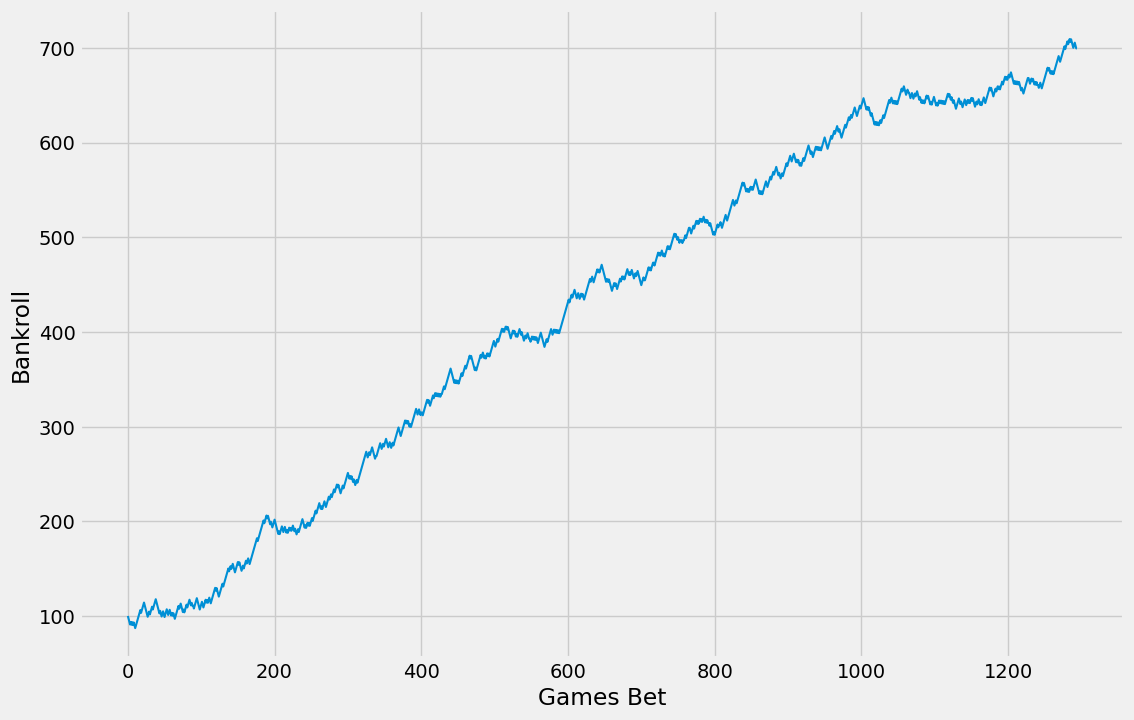

[I 2023-01-09 00:33:19,891] Using an existing study with name 'C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor_backtest1' instead of creating a new one.


min balance: 87.1818181818182 
max balance: 709.2727272727386 
final balance: 696.4545454545569 
win percentage 60.550000000000004 
profit: 596.4545454545455 risk: 3885.0 
ROI: 15.35
roi: 0.15352755352755354 profit: 596.4545454545455 win_pct: 0.6054901960784314

Training Seasons: ['2013-14' '2014-15' '2015-16' '2016-17' '2017-18' '2018-19']
Testing Seasons: ['2019-20']



[I 2023-01-09 00:35:41,291] Trial 20 finished with value: -12.594082766376658 and parameters: {'alpha': 0.05875096403303669, 'l1_ratio': 0.6370965802226993}. Best is trial 1 with value: -8.141931697793895.
[I 2023-01-09 00:38:02,882] Trial 21 finished with value: -12.594082766376658 and parameters: {'alpha': 0.3360125836231322, 'l1_ratio': 0.5789918911384422}. Best is trial 1 with value: -8.141931697793895.
[I 2023-01-09 00:40:23,990] Trial 22 finished with value: -12.594082766376658 and parameters: {'alpha': 1.4213385415786057, 'l1_ratio': 0.4103075601772051}. Best is trial 1 with value: -8.141931697793895.
[I 2023-01-09 00:42:45,468] Trial 23 finished with value: -12.594082766376658 and parameters: {'alpha': 0.396127797654366, 'l1_ratio': 0.5568524907639263}. Best is trial 1 with value: -8.141931697793895.
[I 2023-01-09 00:45:06,506] Trial 24 finished with value: -12.594082766376658 and parameters: {'alpha': 0.12767625075638725, 'l1_ratio': 0.7388651973211054}. Best is trial 1 with v

params: {'alpha': 0.20014548177222843, 'epsilon': 23.529079155386505, 'l1_ratio': 0.842464243443114, 'loss': 'huber'}

train_mae: 8.04123720198765
test_mae: 8.837549328334529

betting results on testing season:


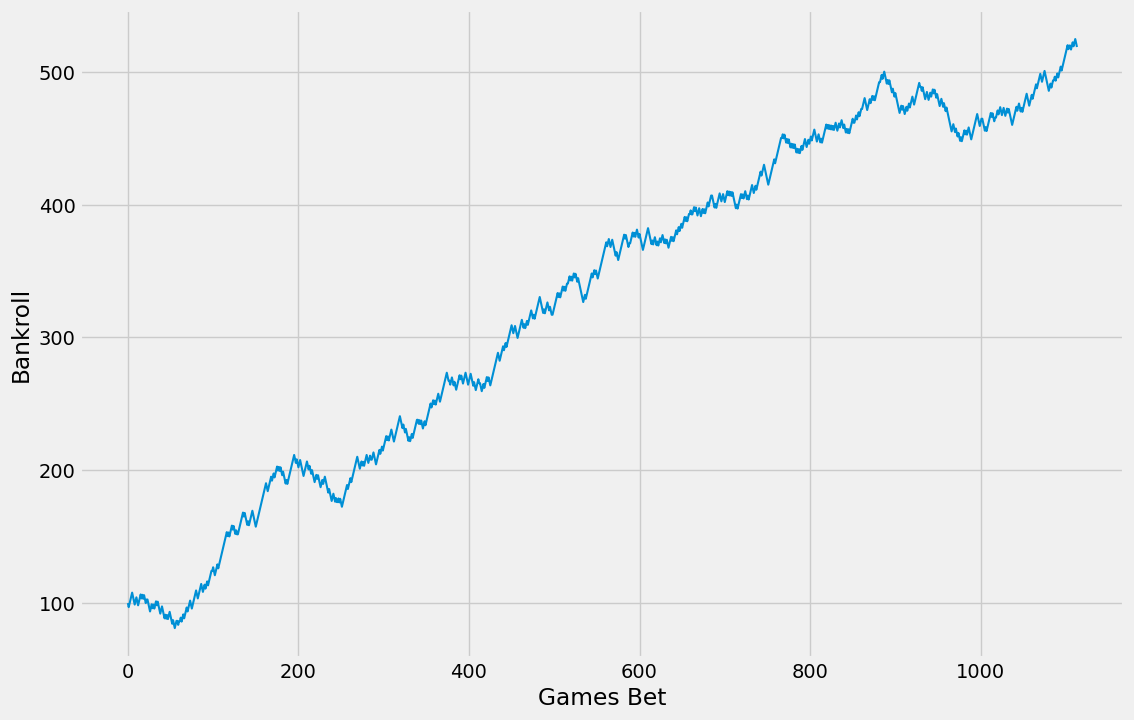

min balance: 81.18181818181834 
max balance: 524.6363636363716 
final balance: 521.3636363636443 
win percentage 59.14 
profit: 421.36363636363626 risk: 3342.0 
ROI: 12.61
roi: 0.1260812795821772 profit: 421.36363636363626 win_pct: 0.5913682277318641

Training Seasons: ['2013-14' '2014-15' '2015-16' '2016-17' '2017-18' '2018-19' '2019-20']
Testing Seasons: ['2020-21']



[I 2023-01-09 01:21:45,279] Using an existing study with name 'C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor_backtest2' instead of creating a new one.
[I 2023-01-09 01:24:46,144] Trial 10 finished with value: -12.75006251159584 and parameters: {'alpha': 0.40833237871553507, 'l1_ratio': 0.4383631134686527}. Best is trial 5 with value: -8.81115274592068.
[I 2023-01-09 01:28:11,775] Trial 11 finished with value: -8.788536900882871 and parameters: {'alpha': 0.00010725574592520544, 'l1_ratio': 0.949647619033103}. Best is trial 11 with value: -8.788536900882871.
[I 2023-01-09 01:31:39,119] Trial 12 finished with value: -8.793587303182811 and parameters: {'alpha': 0.00013149522380377467, 'l1_ratio': 0.9353878116333058}. Best is trial 11 with value: -8.788536900882871.
[I 2023-01-09 01:34:47,634] Trial 13 finished with value: -9.396861687249682 and parameters: {'alpha': 0.0023589523762770057, 'l1_ratio': 0.9404305060306609}. Best is trial 11 wi

params: {'alpha': 0.00010725574592520544, 'l1_ratio': 0.949647619033103}



c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


train_mae: 7.927121720566988
test_mae: 9.085653377625562

betting results on testing season:


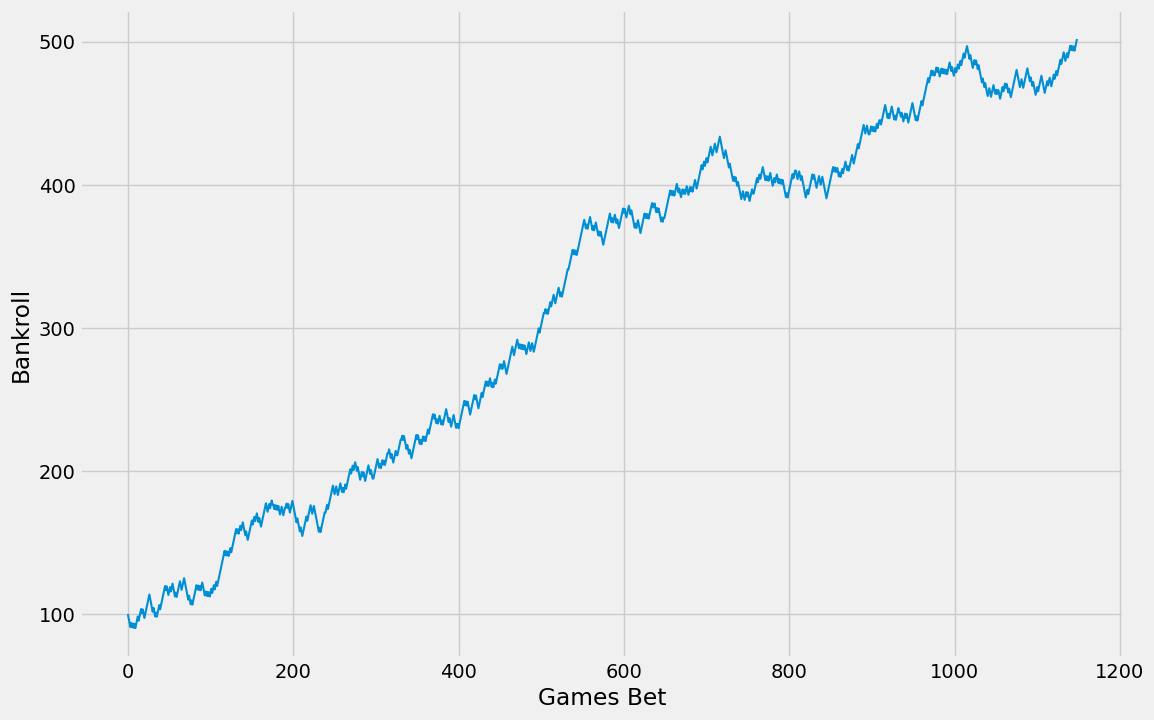

min balance: 90.1818181818182 
max balance: 504.454545454553 
final balance: 504.454545454553 
win percentage 58.64 
profit: 404.45454545454527 risk: 3447.0 
ROI: 11.73
roi: 0.11733523221773869 profit: 404.45454545454527 win_pct: 0.5863596102745793



[I 2023-01-09 02:26:26,915] Using an existing study with name 'C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor_backtest3' instead of creating a new one.


Training Seasons: ['2013-14' '2014-15' '2015-16' '2016-17' '2017-18' '2018-19' '2019-20'
 '2020-21']
Testing Seasons: ['2021-22']



[I 2023-01-09 02:30:22,694] Trial 10 finished with value: -8.921857731543483 and parameters: {'alpha': 0.0013343267911766774, 'l1_ratio': 0.42527404350219944}. Best is trial 10 with value: -8.921857731543483.
[I 2023-01-09 02:34:17,613] Trial 11 finished with value: -8.922679983035271 and parameters: {'alpha': 0.0014133245216461162, 'l1_ratio': 0.41023814416624443}. Best is trial 10 with value: -8.921857731543483.
[I 2023-01-09 02:38:11,969] Trial 12 finished with value: -8.807957636512535 and parameters: {'alpha': 0.00010745073595618011, 'l1_ratio': 0.5558939566912992}. Best is trial 12 with value: -8.807957636512535.
[I 2023-01-09 02:42:04,748] Trial 13 finished with value: -8.807631246860081 and parameters: {'alpha': 0.0001021248206106882, 'l1_ratio': 0.5580346532882076}. Best is trial 13 with value: -8.807631246860081.
[I 2023-01-09 02:46:09,906] Trial 14 finished with value: -8.8190450052464 and parameters: {'alpha': 0.00023260231737118876, 'l1_ratio': 0.5915160343898896}. Best is

params: {'alpha': 0.0001021248206106882, 'l1_ratio': 0.5580346532882076}



c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


train_mae: 8.143209638555918
test_mae: 8.80821144411125

betting results on testing season:


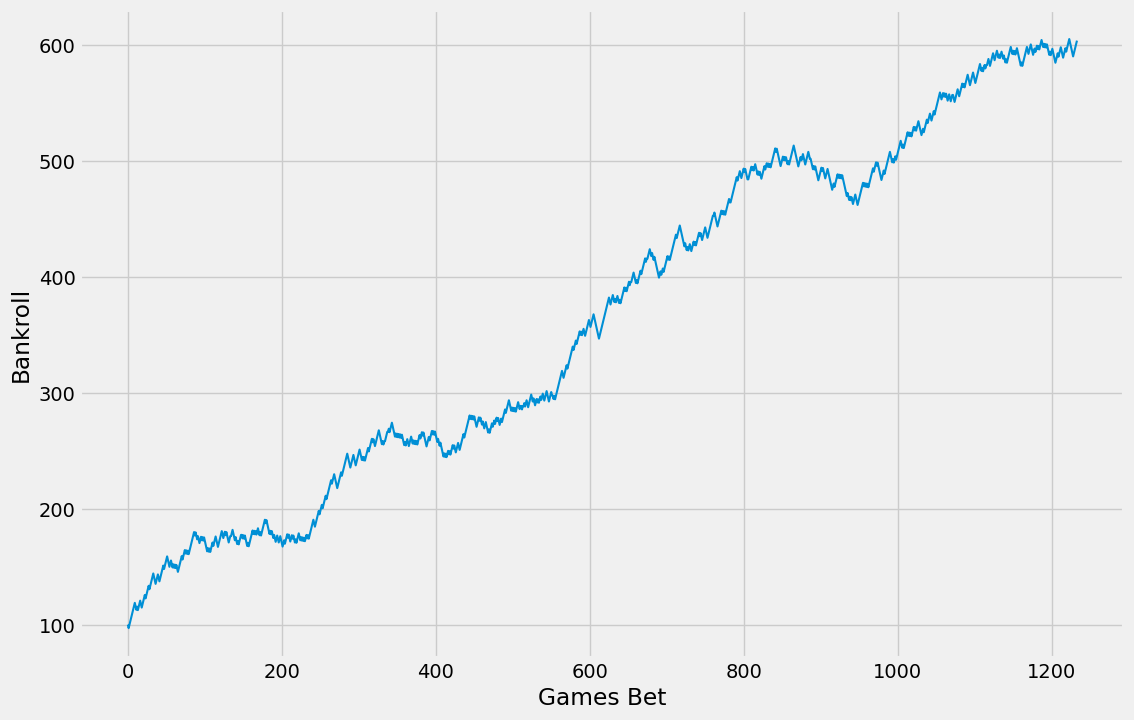

min balance: 97.0 
max balance: 605.3636363636457 
final balance: 601.0000000000094 
win percentage 59.56 
profit: 500.9999999999998 risk: 3702.0 
ROI: 13.530000000000001
roi: 0.13533225283630465 profit: 500.9999999999998 win_pct: 0.5955701394585726



[I 2023-01-09 03:43:41,798] Using an existing study with name 'C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor_backtest4' instead of creating a new one.


Training Seasons: ['2013-14' '2014-15' '2015-16' '2016-17' '2017-18' '2018-19' '2019-20'
 '2020-21' '2021-22']
Testing Seasons: ['2022-23']



[I 2023-01-09 03:48:38,440] Trial 10 finished with value: -8.803816058510993 and parameters: {'alpha': 0.0001419675796670155, 'l1_ratio': 0.9497292539358081}. Best is trial 10 with value: -8.803816058510993.
[I 2023-01-09 03:53:33,576] Trial 11 finished with value: -8.799163520496936 and parameters: {'alpha': 0.00013181324570984846, 'l1_ratio': 0.9416028563278398}. Best is trial 11 with value: -8.799163520496936.
[I 2023-01-09 03:58:25,026] Trial 12 finished with value: -8.791765199035343 and parameters: {'alpha': 0.00010085331172428594, 'l1_ratio': 0.8788980163742595}. Best is trial 12 with value: -8.791765199035343.
[I 2023-01-09 04:03:15,655] Trial 13 finished with value: -8.791815236938087 and parameters: {'alpha': 0.00010197908601161406, 'l1_ratio': 0.8621934706009795}. Best is trial 12 with value: -8.791765199035343.
[I 2023-01-09 04:07:48,500] Trial 14 finished with value: -9.194567756325066 and parameters: {'alpha': 0.0015180048425630745, 'l1_ratio': 0.8538550595940976}. Best i

params: {'alpha': 0.00010436237396482791, 'l1_ratio': 0.8972475320947173}



c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


train_mae: 8.325767404530378
test_mae: 8.811485846151095

betting results on testing season:


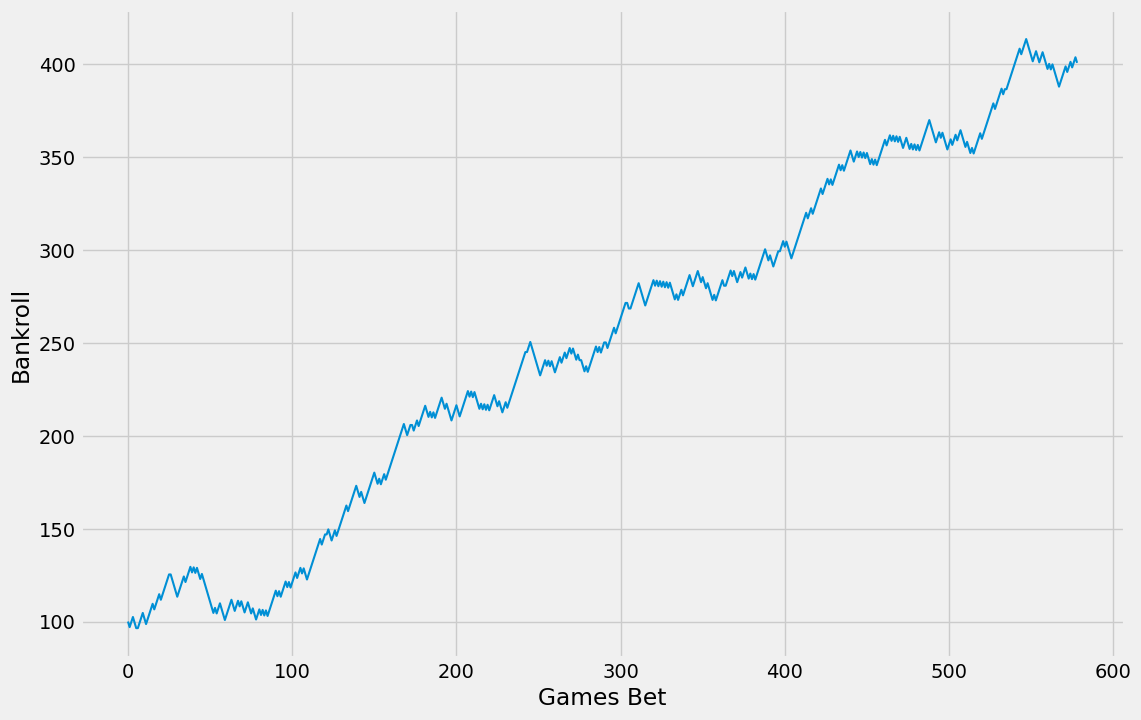

min balance: 96.45454545454547 
max balance: 413.6363636363663 
final balance: 403.5454545454575 
win percentage 61.73 
profit: 303.5454545454545 risk: 1737.0 
ROI: 17.48
roi: 0.1747527084314649 profit: 303.5454545454545 win_pct: 0.6172839506172839



In [332]:
for i in range(len(cv_splits)):
    X_train = X.loc[cv_splits[i][0]]
    y_train = y.loc[cv_splits[i][0]]

    X_test = X.loc[cv_splits[i][1]]
    y_test = y.loc[cv_splits[i][1]]
    hp_cv_splits = tscv_by_season(df.loc[X_train.index], int(df.loc[X_train.index, 'SEASON'].max()[:4]))

    print("Training Seasons:", df.loc[cv_splits[i][0], 'SEASON'].unique())
    print("Testing Seasons:", df.loc[cv_splits[i][1], 'SEASON'].unique())
    print()

    def objective(trial):
        
        sgd_alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
        sgd_l1_ratio = trial.suggest_float('l1_ratio', 0.4, 0.95, log=False)
        # sgd_epsilon = trial.suggest_float('epsilon', 5, 25, log=False)
        # sgd_loss = trial.suggest_categorical('loss', ['huber'])
            
        regressor_obj = Pipeline([('scaler', StandardScaler()),
                                    ('sgd', MultiOutputRegressor(
                                                SGDRegressor(loss = 'huber',
                                                            alpha = sgd_alpha,
                                                            # epsilon = sgd_epsilon,
                                                            penalty = 'elasticnet',
                                                            max_iter = 10000,
                                                            l1_ratio = sgd_l1_ratio,
                                                            shuffle = False,
                                                            random_state = 23)
                                                )
                                    )
                                    ]
                                )
        

        
        score = cross_val_score(regressor_obj, X_train, y_train, cv = hp_cv_splits, scoring = 'neg_mean_absolute_error', error_score='raise')
        
        score_avg = score.mean()
        
        return score_avg



    db_filepath = Path.home().joinpath('NBA_model_v1', 'data', 'nba.db')
    hyperparameter_filepath_out = Path.home().joinpath('NBA_model_v1', 'models', 'hyperparameter_tuning')

    n_trials = 20
    random_state = 23
    model_name = 'SGDRegressor_ScorePredictor_backtest' + str(i)
    study_name = str(Path.home().joinpath('NBA_model_v1', 'models', 'hyperparameter_tuning', model_name))
    storage_name = "sqlite:///{}.db".format(study_name)
        
    study = optuna.create_study(study_name = study_name, direction='maximize', 
                                storage = storage_name, load_if_exists=True)

    study.optimize(objective, n_trials=n_trials)

    params = study.best_params
    
    print("params:", params)
    print()

    best_model = Pipeline([('scaler', StandardScaler()),
                                ('sgd', MultiOutputRegressor(SGDRegressor(**params,                                                                
                                                                shuffle=False,
                                                                random_state=23)))])

    best_model.fit(X_train, y_train)


    # Make Predictions   
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    print("train_mae:", mean_absolute_error(y_train, train_preds))
    print("test_mae:", mean_absolute_error(y_test, test_preds))  

    print()

    betting_df = create_betting_df(test_preds, i)
    
    print("betting results on testing season:")
    result_df, roi, profit, win_pct = simulate_bets_1(selected_bets = betting_df, unit_size=3)
    
    print("roi:", roi, "profit:", profit, "win_pct:", win_pct)
    print()

In [337]:
result_df.loc[result_df['GAME_DATE'] == '2023-01-07', ['SEASON', 'GAME_DATE', 'MATCHUP', 'HOME_SPREAD', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 
           'HOME_SCORE_PRED', 'AWAY_SCORE_PRED', 'HOME_FAVORED','BET_FAVORITE', 'HOME_COVER_PRED', 
           'HOME_TEAM_COVERED', 'ATS_BET_WON', 'bankroll_i', 'bankroll_n']]

selected_bets = result_df.loc[result_df['GAME_DATE']>='2022-12-12']

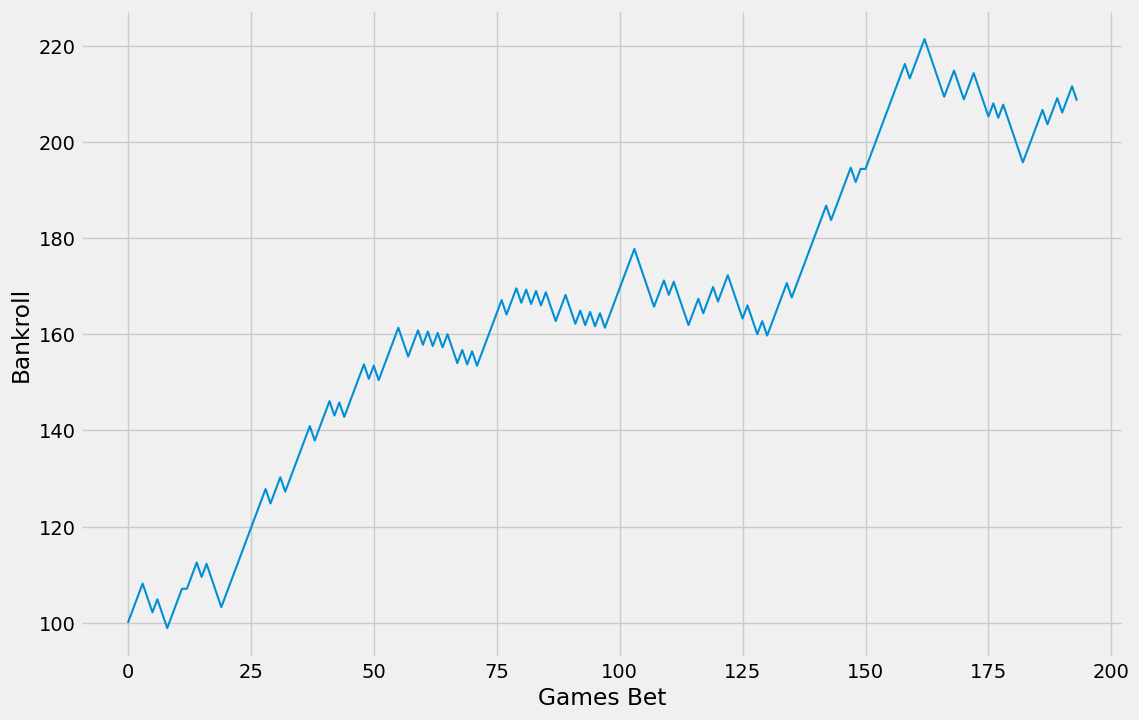

min balance: 98.90909090909093 
max balance: 221.36363636363583 
final balance: 211.27272727272663 
win percentage 62.5 
profit: 111.27272727272725 risk: 582.0 
ROI: 19.12


In [338]:
result_df, roi, profit, win_pct = simulate_bets_1(selected_bets = selected_bets, unit_size=3)




In [320]:
result_df

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,HOME_TEAM_COVERED,...,MODEL_FAV_EQ_VEGAS_FAV,MODEL_ATS_DIFF,MODEL_ATS_DIFF_UNDER_1,MODEL_ATS_DIFF_OVER_1,MODEL_ATS_DIFF_OVER_2,MODEL_ATS_DIFF_OVER_3,MODEL_ATS_DIFF_OVER_4,bankroll_i,bankroll_n,bet_size
0,2022-23,POR,2022-10-21 00:00:00,POR vs. PHX,113,111,2.800000,5.5,7.5,1.0,...,1,-14.337130,0,1,1,1,1,100.000000,97.000000,3.0
1,2022-23,GSW,2022-10-21 00:00:00,GSW vs. DEN,123,128,1.444444,-6.0,-11.0,0.0,...,1,-0.798551,1,0,0,0,0,97.000000,99.727273,3.0
2,2022-23,MIN,2022-10-21 00:00:00,MIN vs. UTA,126,132,1.285714,-8.0,-14.0,0.0,...,1,-1.269603,0,1,0,0,0,99.727273,102.454545,3.0
3,2022-23,NYK,2022-10-21 00:00:00,NYK vs. DET,130,106,1.280112,-7.5,16.5,1.0,...,1,-2.203361,0,1,1,0,0,102.454545,99.454545,3.0
4,2022-23,MIA,2022-10-21 00:00:00,MIA vs. BOS,104,111,2.260000,3.5,-3.5,0.0,...,1,2.892385,0,1,1,0,0,99.454545,96.454545,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,2022-23,DAL,2023-01-07 00:00:00,DAL vs. NOP,127,117,1.239808,-9.0,1.0,1.0,...,1,-4.083417,0,1,1,1,1,401.363636,398.363636,3.0
575,2022-23,GSW,2023-01-07 00:00:00,GSW vs. ORL,101,115,1.377358,-7.0,-21.0,0.0,...,0,-8.559562,0,1,1,1,1,398.363636,401.090909,3.0
576,2022-23,SAS,2023-01-07 00:00:00,SAS vs. BOS,116,121,9.500000,15.5,10.5,1.0,...,1,11.614654,0,1,1,1,1,401.090909,403.818182,3.0
577,2022-23,CHI,2023-01-07 00:00:00,CHI vs. UTA,126,118,2.230000,3.0,11.0,1.0,...,1,-4.304485,0,1,1,1,1,403.818182,400.818182,3.0


,feature_name,coef
535,AWAY_PASS_opp_L20,-15.892157
344,AWAY_TCHS_opp_L5,-15.095199
160,HOME_UFGA_opp_L10,-13.005826
189,HOME_FG2A_L20,-12.375542
158,HOME_CFGA_opp_L10,-11.008799
...,...,...
293,AWAY_AST_L5,9.748903
138,HOME_FTA_opp_L10,9.900529
347,AWAY_PASS_opp_L5,13.827945
92,HOME_TOV_PCT_opp_L5,14.780574


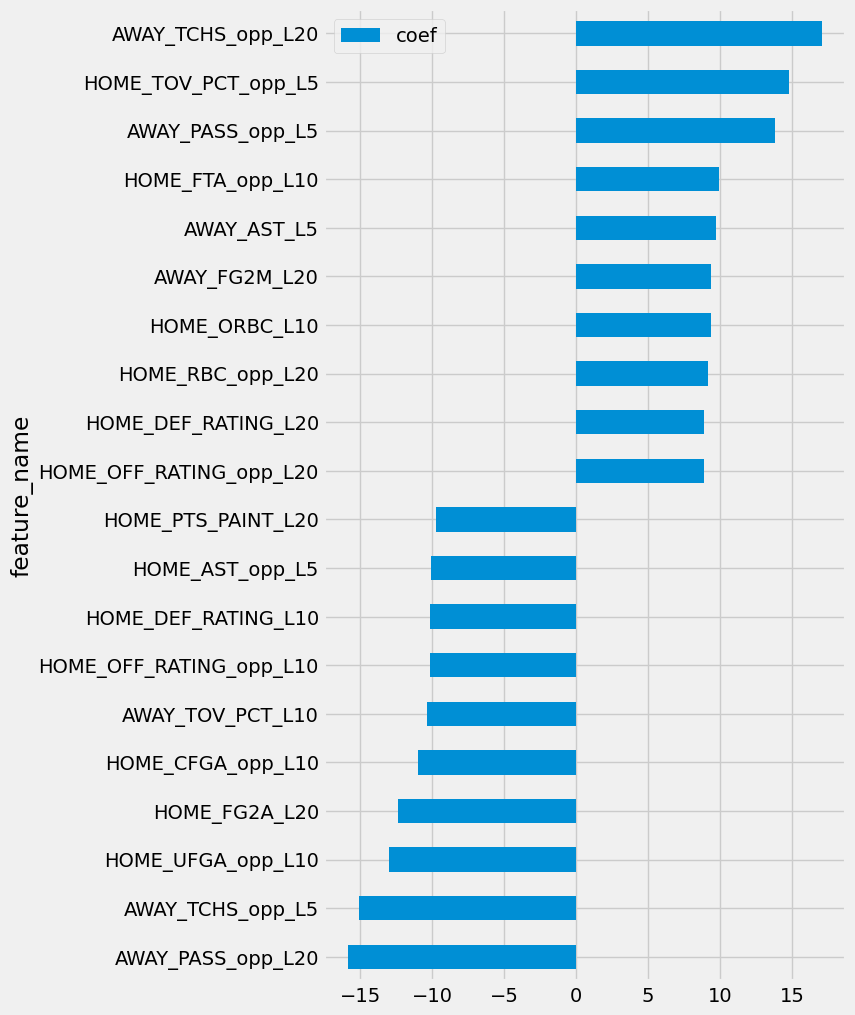

In [314]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

view_model_coefs(best_model.named_steps['sgd'].estimators_[1], X_train)

In [345]:
train_idx = df.loc[df['SEASON'] < '2019-20'].index
test_idx = df.loc[df['SEASON'] >= '2019-20'].index

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test = X.loc[test_idx]
y_test = y.loc[test_idx]


params = {'alpha': 0.20014548177222843, 'epsilon': 23.529079155386505, 'l1_ratio': 0.842464243443114, 'loss': 'huber'}

best_model = Pipeline([('scaler', StandardScaler()),
                            ('sgd', MultiOutputRegressor(SGDRegressor(**params,                                                                
                                                            shuffle=False,
                                                            random_state=23)))])

best_model.fit(X_train, y_train)


# Make Predictions   
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

print("train_mae:", mean_absolute_error(y_train, train_preds))
print("test_mae:", mean_absolute_error(y_test, test_preds))  

print()



train_mae: 8.04123720198765
test_mae: 8.766890180940582



In [357]:
pd.options.display.max_rows=200
df.loc[df['MATCHUP'].str.contains('UTA'), ['HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'HOME_POINT_DIFF', 'HOME_WL', 'HOME_WIN_PCT_L5', 'AWAY_WIN_PCT_L5', 'HOME_WIN_PCT_L10', 'AWAY_WIN_PCT_L10',]].tail(15)

,HOME_TEAM_ABBREVIATION,GAME_DATE,HOME_POINT_DIFF,HOME_WL,HOME_WIN_PCT_L5,AWAY_WIN_PCT_L5,HOME_WIN_PCT_L10,AWAY_WIN_PCT_L10
11323,UTA,2022-12-09 00:00:00,-10,0,0.6,0.4,0.4,0.6
11331,DEN,2022-12-10 00:00:00,5,1,0.4,0.6,0.6,0.3
11350,UTA,2022-12-13 00:00:00,21,1,0.4,1.0,0.3,0.9
11364,UTA,2022-12-15 00:00:00,3,1,0.4,0.8,0.4,0.8
11380,MIL,2022-12-17 00:00:00,26,1,0.6,0.6,0.7,0.5
11390,CLE,2022-12-19 00:00:00,23,1,0.8,0.4,0.7,0.5
11399,DET,2022-12-20 00:00:00,-15,0,0.2,0.4,0.3,0.5
11416,UTA,2022-12-22 00:00:00,8,1,0.6,0.2,0.5,0.1
11441,SAS,2022-12-26 00:00:00,4,1,0.2,0.6,0.4,0.5
11459,GSW,2022-12-28 00:00:00,5,1,0.6,0.4,0.4,0.5


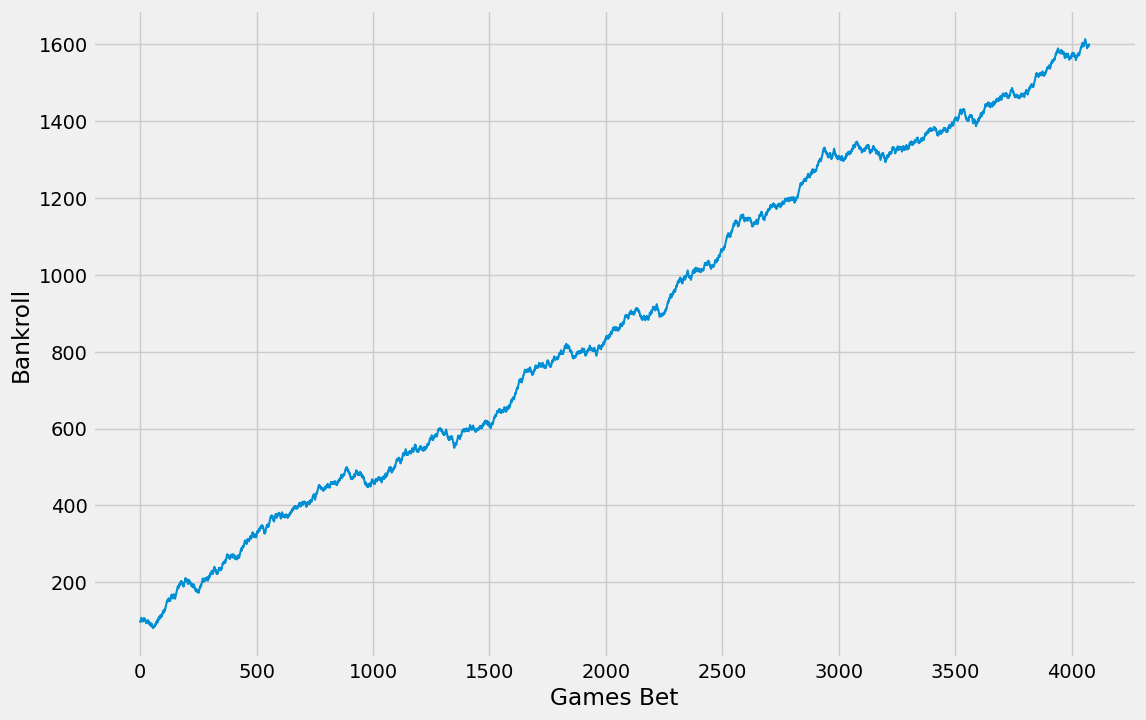

min balance: 81.18181818181834 
max balance: 1612.5454545454977 
final balance: 1598.636363636407 
win percentage 58.919999999999995 
profit: 1498.636363636363 risk: 12228.0 
ROI: 12.26


In [346]:
matchup_info_cols = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'MATCHUP',
                    'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                    'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF', 'HOME_WL']

betting_df = df[matchup_info_cols]

betting_df = betting_df.loc[test_idx]
betting_df[['HOME_SCORE_PRED', 'AWAY_SCORE_PRED']] = test_preds
betting_df['HOME_SCORE_DIFF_PRED'] = betting_df['HOME_SCORE_PRED'] - betting_df['AWAY_SCORE_PRED']

betting_df['HOME_WL_PRED'] = (betting_df['HOME_SCORE_PRED'] > betting_df['AWAY_SCORE_PRED']).astype(int)

betting_df['HOME_FAVORED'] = (betting_df['HOME_SPREAD'] < 0).astype(int)

betting_df['ML_BET_WON'] = (betting_df['HOME_WL_PRED'] == betting_df['HOME_WL']).astype(int)
betting_df['HOME_COVER_PRED'] = (betting_df['HOME_SCORE_PRED'] + betting_df['HOME_SPREAD'] > betting_df['AWAY_SCORE_PRED']).astype(int)
betting_df['ATS_BET_WON'] = (betting_df['HOME_COVER_PRED'] == betting_df['HOME_TEAM_COVERED']).astype(int)


betting_df['BET_FAVORITE'] = (((betting_df['HOME_FAVORED'] == 1) & (betting_df['HOME_COVER_PRED'] == 1)) | ((betting_df['HOME_FAVORED'] == 0) & (betting_df['HOME_COVER_PRED'] == 0))).astype(int)

betting_df['MODEL_FAV_EQ_VEGAS_FAV'] = (np.sign(betting_df['HOME_SPREAD']) != np.sign(betting_df['HOME_SCORE_DIFF_PRED'])).astype(int)
betting_df['MODEL_ATS_DIFF'] = betting_df['HOME_SPREAD'] + betting_df['HOME_SCORE_DIFF_PRED']


betting_df['MODEL_ATS_DIFF_UNDER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() < 1).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 1).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_2'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 2).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_3'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 3).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_4'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 4).astype(int)

betting_df.loc[betting_df['HOME_SPREAD']==0, 'HOME_FAVORED'] = np.nan
betting_df.loc[betting_df['HOME_ATS_DIFF']==0, ['HOME_TEAM_COVERED', 'ATS_BET_WON']] = np.nan

    
result_df, roi, profit, win_pct = simulate_bets_1(selected_bets = betting_df, unit_size=3)




In [286]:
betting_df.groupby(['MODEL_FAV_EQ_VEGAS_FAV', 'HOME_COVER_PRED', 'BET_FAVORITE', 'HOME_WL_PRED', 'MODEL_ATS_DIFF_OVER_3'])['ATS_BET_WON'].agg(('sum', 'count', 'mean'))

sum  \
MODEL_FAV_EQ_VEGAS_FAV HOME_COVER_PRED BET_FAVORITE HOME_WL_PRED MODEL_ATS_DIFF_OVER_3         
0                      0               0            0            0                       1.0   
                                                                 1                      37.0   
                       1               0            1            0                       2.0   
                                                                 1                      72.0   
1                      0               0            1            0                      31.0   
                                                                 1                      34.0   
                                       1            0            0                       8.0   
                                                                 1                      22.0   
                       1               0            0            0                      18.0   
                                                                 1                      20.0   
                                       1            1            0                      27.0   
                                                                 1                      78.0   

                                                                                        count  \
MODEL_FAV_EQ_VEGAS_FAV HOME_COVER_PRED BET_FAVORITE HOME_WL_PRED MODEL_ATS_DIFF_OVER_3          
0                      0               0            0            0                          5   
                                                                 1                         55   
                       1               0            1            0                          6   
                                                                 1                        108   
1                      0               0            1            0                         58   
                                                                 1                         51   
                                       1            0            0                         18   
                                                                 1                         35   
                       1               0            0            0                         30   
                                                                 1                         23   
                                       1            1            0                         55   
                                                                 1                        123   

                                                                                            mean  
MODEL_FAV_EQ_VEGAS_FAV HOME_COVER_PRED BET_FAVORITE HOME_WL_PRED MODEL_ATS_DIFF_OVER_3            
0                      0               0            0            0                      0.200000  
                                                                 1                      0.672727  
                       1               0            1            0                      0.333333  
                                                                 1                      0.666667  
1                      0               0            1            0                      0.534483  
                                                                 1                      0.666667  
                                       1            0            0                      0.444444  
                                                                 1                      0.628571  
                       1               0            0            0                      0.600000  
                                                                 1                      0.869565  
                                       1            1            0                      0.490909  
                                                                 1                      0.634146

In [279]:
betting_df.loc[betting_df['GAME_DATE'].between('2022-10-19', '2023-01-07'), ['HOME_COVER_PRED', 'HOME_TEAM_COVERED', 'ATS_BET_WON']].sum()

HOME_COVER_PRED      351.0
HOME_TEAM_COVERED    303.0
ATS_BET_WON          347.0
dtype: float64

In [275]:
betting_df.loc[betting_df['GAME_DATE'].between('2022-10-19', '2023-01-07'), ['HOME_COVER_PRED', 'ATS_BET_WON']].mean()

HOME_COVER_PRED    0.611498
ATS_BET_WON        0.617438
dtype: float64

In [276]:
betting_df

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,HOME_TEAM_COVERED,...,HOME_COVER_PRED,ATS_BET_WON,BET_FAVORITE,MODEL_FAV_EQ_VEGAS_FAV,MODEL_ATS_DIFF,MODEL_ATS_DIFF_UNDER_1,MODEL_ATS_DIFF_OVER_1,MODEL_ATS_DIFF_OVER_2,MODEL_ATS_DIFF_OVER_3,MODEL_ATS_DIFF_OVER_4
10965,2022-23,POR,2022-10-21 00:00:00,POR vs. PHX,113,111,2.800000,5.5,7.5,1.0,...,0,0.0,1,1,-14.337130,0,1,1,1,1
10964,2022-23,GSW,2022-10-21 00:00:00,GSW vs. DEN,123,128,1.444444,-6.0,-11.0,0.0,...,0,1.0,0,1,-0.798551,1,0,0,0,0
10963,2022-23,MIN,2022-10-21 00:00:00,MIN vs. UTA,126,132,1.285714,-8.0,-14.0,0.0,...,0,1.0,0,1,-1.269603,0,1,0,0,0
10961,2022-23,NYK,2022-10-21 00:00:00,NYK vs. DET,130,106,1.280112,-7.5,16.5,1.0,...,0,0.0,0,1,-2.203361,0,1,1,0,0
10960,2022-23,MIA,2022-10-21 00:00:00,MIA vs. BOS,104,111,2.260000,3.5,-3.5,0.0,...,1,0.0,0,1,2.892385,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11531,2022-23,DAL,2023-01-07 00:00:00,DAL vs. NOP,127,117,1.239808,-9.0,1.0,1.0,...,0,0.0,0,1,-4.083417,0,1,1,1,1
11532,2022-23,GSW,2023-01-07 00:00:00,GSW vs. ORL,101,115,1.377358,-7.0,-21.0,0.0,...,0,1.0,0,0,-8.559562,0,1,1,1,1
11529,2022-23,SAS,2023-01-07 00:00:00,SAS vs. BOS,116,121,9.500000,15.5,10.5,1.0,...,1,1.0,0,1,11.614654,0,1,1,1,1
11530,2022-23,CHI,2023-01-07 00:00:00,CHI vs. UTA,126,118,2.230000,3.0,11.0,1.0,...,0,0.0,1,1,-4.304485,0,1,1,1,1


In [241]:
betting_df[['SEASON', 'GAME_DATE', 'MATCHUP', 'HOME_SPREAD', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SCORE_PRED', 'AWAY_SCORE_PRED', 'HOME_FAVORED','BET_FAVORITE', 'HOME_COVER_PRED', 'HOME_TEAM_COVERED', 'ATS_BET_WON']].head(15)

,SEASON,GAME_DATE,MATCHUP,HOME_SPREAD,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED,HOME_FAVORED,BET_FAVORITE,HOME_COVER_PRED,HOME_TEAM_COVERED,ATS_BET_WON
7466,2019-20,2019-10-25 00:00:00,LAL vs. UTA,-4.0,95,86,106.218683,114.412288,1.0,0,0,1.0,0.0
7465,2019-20,2019-10-25 00:00:00,SAC vs. POR,2.0,112,122,105.514631,116.165659,0.0,1,0,0.0,1.0
7464,2019-20,2019-10-25 00:00:00,DEN vs. PHX,-12.0,108,107,115.061047,104.872937,1.0,0,0,0.0,1.0
7463,2019-20,2019-10-25 00:00:00,OKC vs. WAS,-9.0,85,97,114.788994,108.217446,1.0,0,0,0.0,1.0
7460,2019-20,2019-10-25 00:00:00,BKN vs. NYK,-8.0,113,109,107.994317,103.431937,1.0,0,0,0.0,1.0
7461,2019-20,2019-10-25 00:00:00,MEM vs. CHI,2.5,102,110,114.576760,110.752654,0.0,0,1,0.0,0.0
7459,2019-20,2019-10-25 00:00:00,CHA vs. MIN,5.5,99,121,109.774938,108.749742,0.0,0,1,0.0,0.0
7458,2019-20,2019-10-25 00:00:00,BOS vs. TOR,-3.0,112,106,106.598974,104.632365,1.0,0,0,1.0,0.0
7462,2019-20,2019-10-25 00:00:00,NOP vs. DAL,-2.0,116,123,108.072438,115.813464,1.0,0,0,0.0,1.0
7474,2019-20,2019-10-26 00:00:00,SAS vs. WAS,-11.5,124,122,117.589255,108.299831,1.0,0,0,0.0,1.0


In [246]:
betting_df[['HOME_FAVORED', 'BET_FAVORITE', 'HOME_COVER_PRED', 'HOME_TEAM_COVERED', 'ML_BET_WON', 'ATS_BET_WON']].mean()

HOME_FAVORED         0.595041
BET_FAVORITE         0.346499
HOME_COVER_PRED      0.308797
HOME_TEAM_COVERED    0.491276
ML_BET_CORRECT       0.682226
ATS_BET_WON          0.591368
dtype: float64

In [15]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'ATS_BET_WON'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'ATS_BET_WON'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [16]:
bet_results_1, roi, profit, win_pct = simulate_bets_1(lgbm_preds, unit_size=3)

KeyError: 'ATS_BET_WON'

In [12]:
def season_to_string(x):
    return str(x) + '-' + str(x+1)[-2:]

def get_data_from_db(target, con, test_season):
    
        
    test_season_str = season_to_string(test_season)
    

    df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup', con=con)
    df = df.drop(columns=['index'])

    df = df.sort_values('GAME_DATE')

    df = df.dropna()

    columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                        'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                        'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                        'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE']

    train_df = df.loc[df['SEASON'] < test_season_str]
    test_df = df.loc[df['SEASON'] >= test_season_str]

    X_train = train_df.drop(columns=columns_to_drop)
    y_train = train_df[target]

    X_test = test_df.drop(columns=columns_to_drop)
    y_test = test_df[target]
    
    return X_train, X_test, y_train, y_test, train_df, test_df


db_filepath = Path.home().joinpath('NBA_model_v1', 'data', 'nba.db')

# get data
connection = sqlite3.connect(db_filepath)
X_train, X_test, y_train, y_test, train_df, test_df = get_data_from_db(target=['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE'], con=connection, test_season=2021)
connection.close()

# get best hyperparameters
model_name = 'SGDRegressor_ScorePredictor'
study_name = str(Path.home().joinpath('NBA_model_v1', 'models', 'hyperparameter_tuning', model_name))    
storage_name = "sqlite:///{}.db".format(study_name)

print("study_name:", study_name)
print("storage_name:", storage_name)

study = optuna.load_study(study_name = study_name, storage = storage_name)

params = study.best_params
print(params)

# instantiate model with hyperparameters
model = Pipeline([('scaler', StandardScaler()),
                            ('sgd', MultiOutputRegressor(SGDRegressor(**params,                                                                
                                                            shuffle=False,
                                                            random_state=23)))])


# fit model
model.fit(X_train, y_train)

# Calculate MAE scores

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("train_mae before removing correlated features", mean_absolute_error(y_train, train_preds))
print("test_mae before removing correlated features", mean_absolute_error(y_test, test_preds))

study_name: C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor
storage_name: sqlite:///C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor.db
{'alpha': 0.04008569825513905, 'epsilon': 5.2966062017695155, 'l1_ratio': 0.9498835228685188, 'loss': 'huber'}
train_mae before removing correlated features 8.03050663544888
test_mae before removing correlated features 8.63782112873468


In [20]:
features = ['HOME_FG2M_L5', 'HOME_FTM_L5', 'HOME_TS_PCT_L5', 'HOME_EFG_PCT_L5',
       'HOME_FG3A_L10', 'HOME_PACE_L10', 'HOME_PLUS_MINUS_L20',
       'HOME_OFF_RATING_L20', 'HOME_AVG_ATS_DIFF_L20', 'HOME_POSS_opp_L20',
       'AWAY_FG2M_L5', 'AWAY_TS_PCT_L5', 'AWAY_EFG_PCT_L5', 'AWAY_FG3A_L10',
       'AWAY_FTM_L10', 'AWAY_AVG_ATS_DIFF_L10', 'AWAY_RBC_opp_L10',
       'AWAY_PACE_L20', 'AWAY_PTS_opp_L20', 'AWAY_PIE_L20']

X_train_selected = X_train[features]
X_test_selected = X_test[features]

model.fit(X_train_selected, y_train)

# Calculate MAE scores

train_preds = model.predict(X_train_selected)
test_preds = model.predict(X_test_selected)

print("train_mae", mean_absolute_error(y_train, train_preds))
print("test_mae", mean_absolute_error(y_test, test_preds))


matchup_info = test_df[['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE']].copy(deep=True)

matchup_info['HOME_SCORE_PRED'] = test_preds[:, 0]
matchup_info['AWAY_SCORE_PRED'] = test_preds[:, 1]


df_sgd_selected_bets = make_betting_df(matchup_info)

train_mae 8.14102778540672
test_mae 8.63417857342205


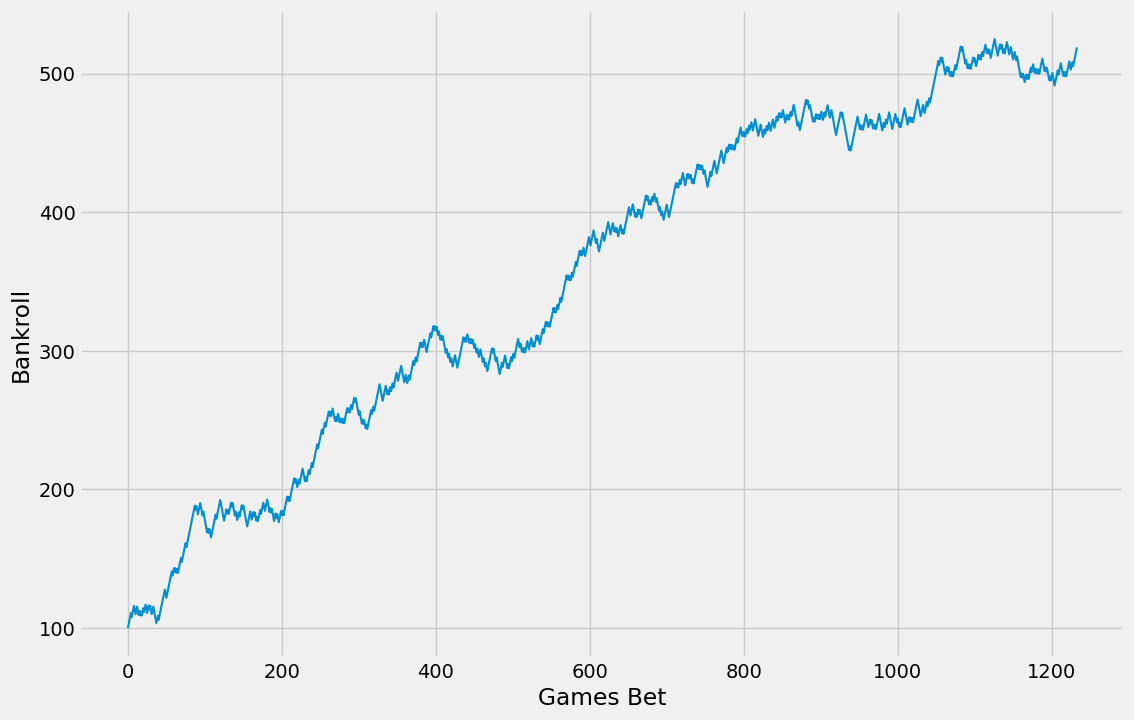

min balance: 102.72727272727273 
max balance: 524.9090909090999 
final balance: 521.6363636363737 
win percentage 58.35 
profit: 421.6363636363635 risk: 3702.0 
ROI: 11.39


(      index   SEASON HOME_TEAM_ABBREVIATION            GAME_DATE     GAME_ID  \
 0      9729  2021-22                    LAL  2021-10-22 00:00:00  0022100025   
 1      9728  2021-22                    DEN  2021-10-22 00:00:00  0022100024   
 2      9727  2021-22                    HOU  2021-10-22 00:00:00  0022100023   
 3      9726  2021-22                    CHI  2021-10-22 00:00:00  0022100022   
 4      9730  2021-22                    SAC  2021-10-22 00:00:00  0022100026   
 ...     ...      ...                    ...                  ...         ...   
 1229  10950  2021-22                    GSW  2022-06-05 00:00:00  0042100402   
 1230  10951  2021-22                    BOS  2022-06-08 00:00:00  0042100403   
 1231  10952  2021-22                    BOS  2022-06-10 00:00:00  0042100404   
 1232  10953  2021-22                    GSW  2022-06-13 00:00:00  0042100405   
 1233  10954  2021-22                    BOS  2022-06-16 00:00:00  0042100406   
 
           MATCHUP  HOME_H

In [22]:
simulate_bets_1(df_sgd_selected_bets, unit_size=3)

In [29]:
df_sgd_selected_bets[['HOME_TEAM_ABBREVIATION', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SCORE_PRED', 'AWAY_SCORE_PRED']].head(20)

,HOME_TEAM_ABBREVIATION,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED
9729,LAL,LAL vs. PHX,105,115,101.409106,106.195191
9728,DEN,DEN vs. SAS,102,96,119.125615,113.264314
9727,HOU,HOU vs. OKC,124,91,118.108227,108.858291
9726,CHI,CHI vs. NOP,128,112,112.328137,104.627422
9730,SAC,SAC vs. UTA,101,110,110.267397,111.673057
9724,BOS,BOS vs. TOR,83,115,111.706785,110.630277
9723,WAS,WAS vs. IND,135,134,116.696698,125.644524
9722,ORL,ORL vs. NYK,96,121,94.802839,103.981064
9721,CLE,CLE vs. CHA,112,123,114.231737,116.522946
9725,PHI,PHI vs. BKN,109,114,110.523665,108.128731


In [28]:
sgd_preds[['HOME_TEAM_ABBREVIATION', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SCORE_PRED', 'AWAY_SCORE_PRED']].head(20)

,HOME_TEAM_ABBREVIATION,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED
0,LAL,LAL vs. PHX,105,115,97.196346,104.648777
1,DEN,DEN vs. SAS,102,96,117.205307,113.625334
2,HOU,HOU vs. OKC,124,91,117.503751,104.458620
3,CHI,CHI vs. NOP,128,112,115.026841,102.441450
4,SAC,SAC vs. UTA,101,110,110.616742,109.058593
5,BOS,BOS vs. TOR,83,115,109.327167,112.588914
6,WAS,WAS vs. IND,135,134,116.580948,127.422853
7,ORL,ORL vs. NYK,96,121,91.693906,100.877446
8,CLE,CLE vs. CHA,112,123,109.261717,115.928418
9,PHI,PHI vs. BKN,109,114,111.162562,106.539837
